# Binary Image Classification: Dogs and Cats

This notebook documents an approach to the binary classification of images of Dogs and Cats utilizing the best practices of the fast.ai libraries built on top of PyTorch. The approach will start with a ResNet convolutional model pre-trained on the ImageNet dataset. Additional/final dense layer(s) are appended to/retrained after the base convolutional layers. This particular notebook borrows very heavily from fast.ai's Lesson 1 Notebook. 

*Author*: ksferguson (K. Scott Ferguson)

*Type*: Deep Learning

*Stack*: fast.ai over pyTorch

*Pattern*: Binary Image Classification

*Problem*: Predict whether image is dog or cat

*Dataset*: Kaggle - Dogs vs Cats

## fast.ai Best Practices 

### Train a world-class image classifier 
(adapted from fast.ai Lessons 1-3 Videos & Notebooks)

A. Quick Start
  * Use pre-trained Imagenet model
  * Precompute activations in convolutional layers

B. Explore Data

C. Find Learning Rate
  * Find highest learning rate where loss is still decreasing well

D. Train Last Layer(s)
  * Use pre-trained Imagenet model
  * Precompute activations in convolutional layers
  * Use highest learning rate where loss is still decreasing
  * Train 1-2 Epochs

E. Deep Train Last Layer(s)
  * Start recomputing activations in convolutional layers
  * Augment image data with pans, flips, & zooms
  * Restart SGD every epoch (cycle_len=1)
  * Train 2-3 Epochs

F. Train Full Model
  * Unfreeze All Layers
  * Recheck Learning Rate for Final Layer
  * Use Differential Learning Rates
  * SGD Differential Restart, set cycle_mult=2
  * Use Test Time Data Augmentation

G. Analyze Results

## Machine & Notebook Setup

Notebook work is primarily executed on PaperSpace fast.ai template on an 8 CPU, Quadro P5000 GPU, 30 GB RAM machine. Alternatively, a Dell 7759 w GTX 960M was similarly configured although this was a complex and iterative, systems configuration task. Use of PaperSpace is highly encouraged.

* Ubuntu Setup Notes for Dell 7559 with GTX 960M: https://gist.github.com/ksferguson/a6eba79df658826cacb629dcc14992eaPaperSpace 
* fast.ai PaperSpace Setup Notes: https://gist.github.com/ksferguson/0b384e892689617d1539d35c1254eb01 

### fast.ai prelims
Ported largely unchanged.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

### Data Prelims

This problem utilizes one of the fast.ai supported data patterns, based on directory paths (as opposed to e.g. a .csv file with appropriate training set/target label attributes). 

With this pattern, the expectation is that a data directory exists, e.g. "data/dogscats/". Under this folder, there are e.g. "train" and "valid" folders each with a subdirectory for "dogs" and also one for "cats". Hence the target labels are read off the folder geometry.

An initial image size sz is also set to 224 pixels (square, i.e. 224 x 224 or ~50K pixels x 3 color channels for an input tensor with 150,528 data points).

Note: The "data" folder is be a symbolic link inside the repo so that it actually lives outside of the github.com repo.

In [6]:
PATH = "data/dogscats/"
#PATH = "data/kmlc-challenge-1-cats-vs-dogs/"
sz=224

In [7]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

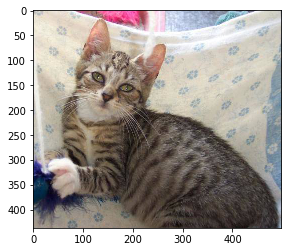

In [10]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(437, 499, 3)

In [12]:
img[:4,:4]

array([[[211, 211, 219],
        [210, 211, 216],
        [208, 207, 213],
        [202, 201, 206]],

       [[200, 201, 206],
        [199, 198, 204],
        [196, 195, 200],
        [193, 192, 197]],

       [[193, 192, 197],
        [189, 188, 193],
        [184, 183, 188],
        [185, 185, 187]],

       [[197, 195, 198],
        [189, 187, 190],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

In [13]:
files = os.listdir(f'{PATH}valid/dogs')[:5]
files

['dog.2851.jpg',
 'dog.8500.jpg',
 'dog.7275.jpg',
 'dog.6665.jpg',
 'dog.1150.jpg']

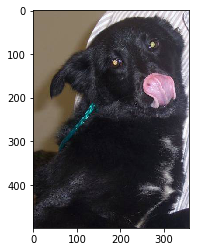

In [14]:
img = plt.imread(f'{PATH}valid/dogs/{files[0]}')
plt.imshow(img);

In [15]:
img.shape

(499, 357, 3)

## A. Quick Start

Use pretrained ImageNet model to start with precomputed activations for initial convolutional layers.

### Use Pre-Trained ImageNet model

Since the pictures are generally similar to ImageNet, we are using resnet34 as a base for the training. Note that following four lines trained in < 15 seconds and hit 99% accuracy. Downloading the model and precomputing activations took 37 secs and 71 seconds respectively. On ResNets see <cite data-cite="5864161/NWGBE6MP"></cite> and https://github.com/KaimingHe/deep-residual-networks.

### Precompute Activations in Convolutional Layers

Set precompute=True for learner to compute activations once prior to training. Later we will disable this initial speedup.

In [16]:
# Uncomment the line below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [17]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.054988   0.027114   0.99      
    1      0.051801   0.029128   0.99                         



[array([0.02913]), 0.99]

Note that _initial_ results are better than state of the art after the original Dogs vs Cats Kaggle competition.

I attempted to save after various rounds, but didn't find it was possible to return to an earlier state once the 'learn' model had been changed. I would need to review code to determine exact formulation of this caveat.

In [18]:
learn.save('DvC_224_A_Quick_Start')

In [19]:
learn.load('DvC_224_A_Quick_Start')

## B. Explore Data & Initial Predictions



In [20]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [22]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [23]:
log_preds[:10]

array([[ -0.00005, -10.00109],
       [ -0.00207,  -6.18328],
       [ -0.00107,  -6.83901],
       [ -0.00083,  -7.09149],
       [ -0.00013,  -8.98384],
       [ -0.00022,  -8.42473],
       [ -0.00018,  -8.64837],
       [ -0.00006,  -9.73839],
       [ -0.00152,  -6.49025],
       [ -0.00008,  -9.44573]], dtype=float32)

In [24]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [25]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [26]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [27]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [28]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


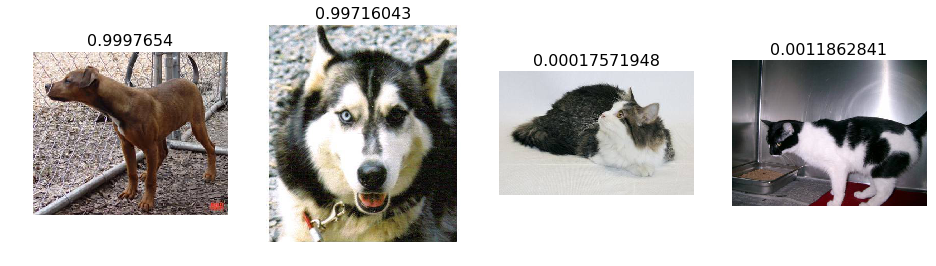

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


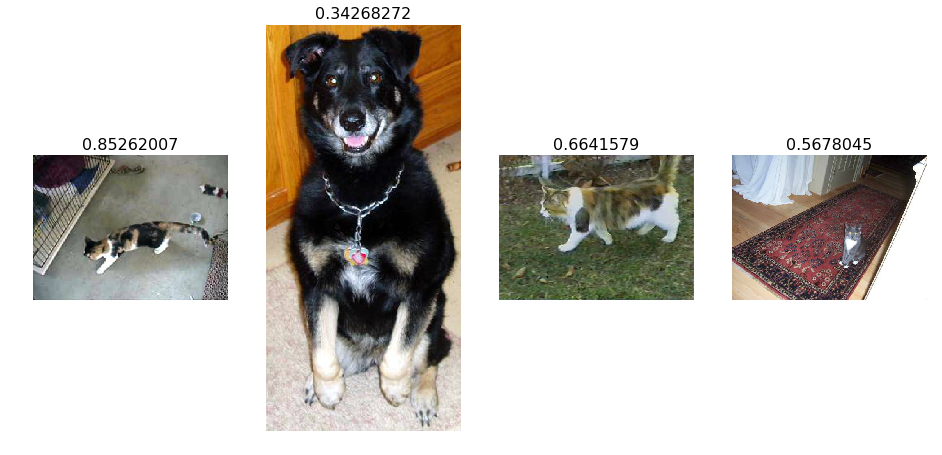

In [30]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [31]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


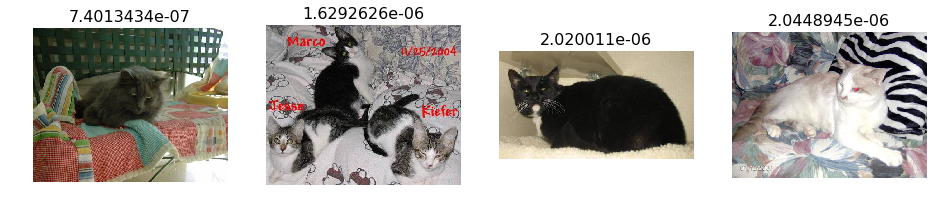

In [32]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


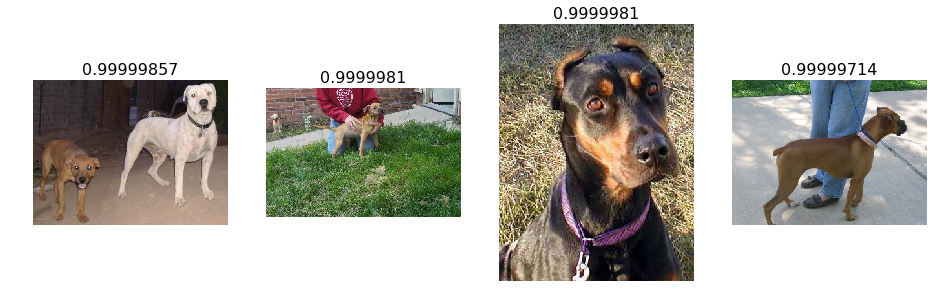

In [33]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


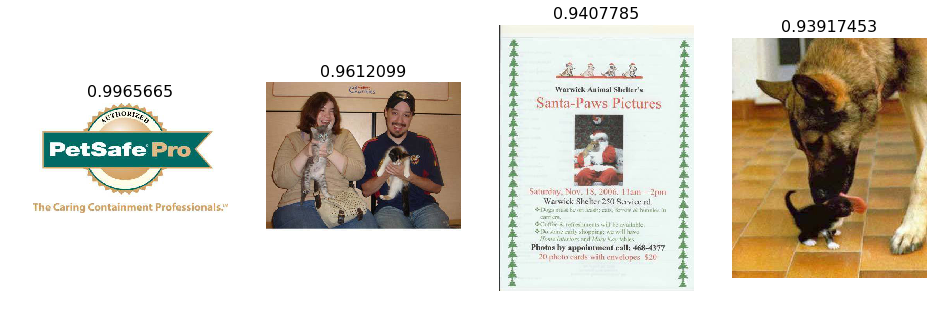

In [34]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


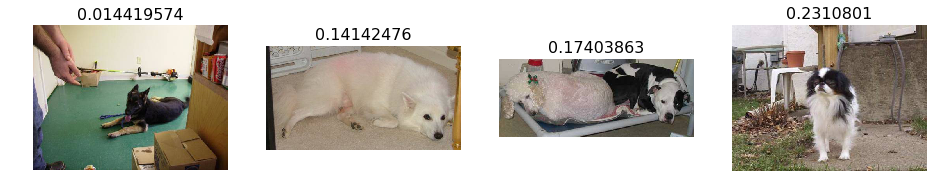

In [35]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


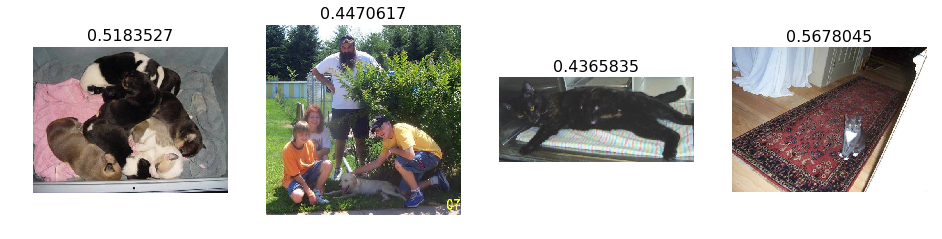

In [36]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## C. Find Learning Rate

Utilize the fast.ai library to determine the best initial learning rate for the last layer(s). This technique was developed in <cite data-cite="5864161/DDHQEL5Q"></cite> 

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
lrf=learn.lr_find()

 85%|████████▍ | 305/360 [00:05<00:00, 58.94it/s, loss=0.503]


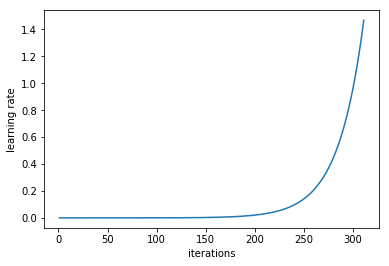

In [39]:
learn.sched.plot_lr()

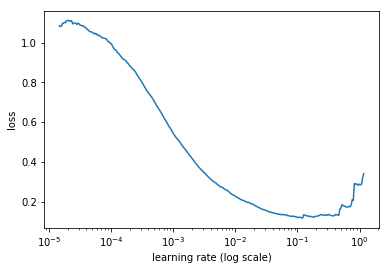

In [40]:
learn.sched.plot()

Loss is still rapidly dropping at $10^{-2}$, so we will set lr=0.01

## D. Train Last Layer(s)

### Use pre-trained Imagenet model
Same as quick start.

### Precompute activations in convolutional layers
Same as quick start.

### Use highest learning rate where loss is still decreasing
lr = $10^{-2}$

### Train 1-2 Epochs

In [41]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.052896   0.028882   0.989     
    1      0.036768   0.031144   0.9875                       



[array([0.03114]), 0.9875]

In [42]:
learn.save('DvC_224_D_Init_Train_Last_Layer')

In [43]:
learn.load('DvC_224_D_Init_Train_Last_Layer')

## E. Deep Train Last Layer 

### Start recomputing activations in convolutional layers
Set precompute=False

### Restart SGD every epoch (cycle_len=1)
Set cycle_len=1 for restart stochastic gradient descent by raising the learning rate up higher again (e.g. to help jump out of 'narrow' minima). See <cite data-cite="5864161/IKEGXYZ9"></cite> for technique.

### Train 2-3 Epochs


### Augment image data with pans, flips, & zooms
Use tfms_from_model() to build various alternate data inputs
transform_side_on is for images take from side (as opposed to top down)

In [44]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [45]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [46]:
ims = np.stack([get_augs() for i in range(6)])

Example data augmentation for side images:

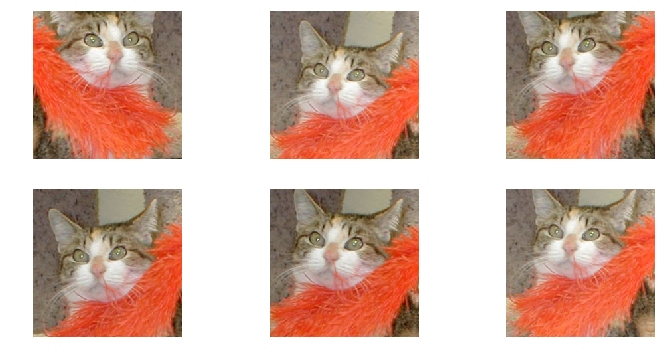

In [47]:
plots(ims, rows=2)

In [48]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [49]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.049932   0.035237   0.99      



[array([0.03524]), 0.99]

In [50]:
learn.precompute=False

In [51]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.041293   0.02628    0.9885    
    1      0.04102    0.024689   0.991                        
    2      0.037984   0.025431   0.991                        



[array([0.02543]), 0.991]

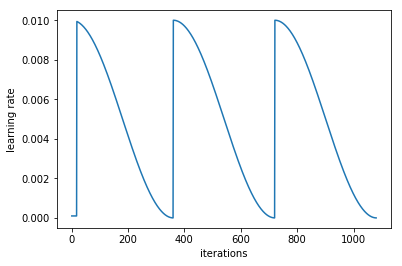

In [52]:
learn.sched.plot_lr()

In [53]:
learn.save('DvC_224_E_Deep-Train_Last_Layer')

In [54]:
learn.load('DvC_224_E_Deep-Train_Last_Layer')

## F. Train Full Model

### Unfreeze All Layers
All layers can now be changed.

### Use Differential Learning Rates
But we don't want the early convolutional layers disturbed as they presumably capture important low level features, so we will use differential rates, apllying a smaller learning rates to earlier layers (in three sets/rates). We will set earlier layers to 3x-10x lower learning rate than next higher layer.

### Use Test Time Data Augmentation
At Test Time, we can use additional data pans, zooms, & flips to bring otherwise hidden pixels or distorted areas into better focus.

In [55]:
lr=np.array([1e-4,1e-3,1e-2])
learn.unfreeze
lrf=learn.lr_find()

 77%|███████▋  | 278/360 [00:48<00:14,  5.69it/s, loss=0.132] 

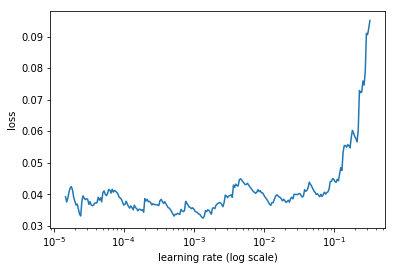

In [56]:
learn.sched.plot()

In [58]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.041519   0.026477   0.989     
    1      0.042483   0.025051   0.988                        
    2      0.040951   0.029729   0.989                        
    3      0.040629   0.027448   0.99                         
    4      0.034826   0.026334   0.9905                       
    5      0.032401   0.026576   0.99                         
    6      0.03274    0.0263     0.99                         


[array([0.0263]), 0.99]

In [59]:
learn.save('DvC_224_F_Train_Full_Model')

In [60]:
learn.load('DvC_224_F_Train_Full_Model')

### Test Time Augmentation

Find highest probablity for each set of the multiple generated images

In [61]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [62]:
accuracy_np(probs, y)

0.9915

## G. Analyze Results



### Confusion Matrix

In [63]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[992   8]
 [  9 991]]


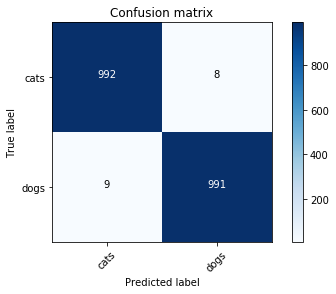

In [65]:
plot_confusion_matrix(cm, data.classes)

### Pictures

Most incorrect cats


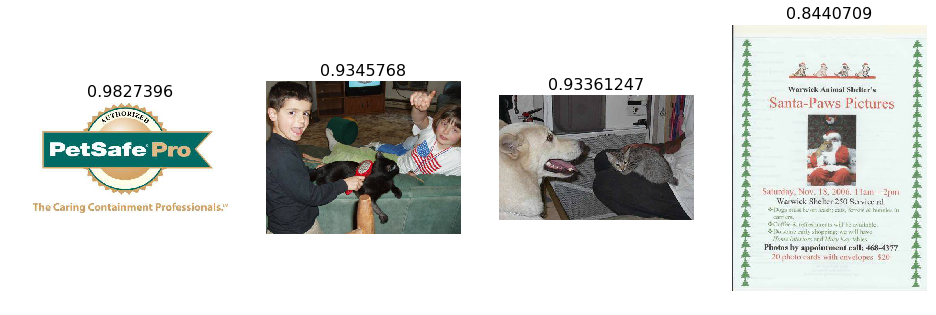

In [66]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


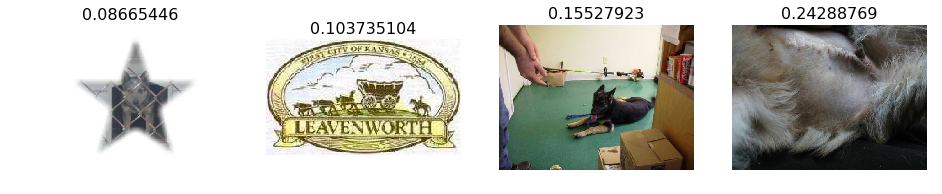

In [67]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## References

fast.ai Deep Learning Course 1:
  * Lesson 1 Notebook, Image classification with Convolutional Neural Networks, https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb
  * Lesson 2 Notebook, Multi-label classification, https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb
  * Lesson 1 Video, Recognizing Cats & Dogs, http://course.fast.ai/lessons/lesson3.html 
  * Lesson 2 Video, Convolutional Neural Networks, http://course.fast.ai/lessons/lesson3.html 
  * Lesson 3 Video, Improving Your Image Classifier, http://course.fast.ai/lessons/lesson3.html 
  
Datasets/Competitions:
  * https://www.kaggle.com/c/dogs-vs-cats
  * https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (same data set as original)
  * https://www.kaggle.com/c/kmlc-challenge-1-cats-vs-dogs/data (new Google data set)
  
References:
<div class="cite2c-biblio"></div>
